# Predicting the VIX using Autoregressive Models on the S&P 500

This study comprised of building a handful of autoregressive models to predict variance in the S&P 500 to try and predict spikes in the VIX, and then determine which one would be the most effective. To determine which model type seemed to be the most effective, I used the forcasting feature in the arch module to see how effectively the model forcasts upcoming volatility. This was forcast over the out-of-sample dataset using a rolling window process. (in order to ensure that the horizon doesn't get too long)

The models used were as follows:

- ARCH(p) 
- GARCH(p,q) 
- HARCH
- EGARCH



Step by step process:

1: Determine which models to test (4 chosen above)

2: Create each model using different parameters (I.E. have a bunch of sub-models)

3: For each model with specific parameters evaluate its forcasting effectiveness by doing a rolling window

    a. by rolling window I mean predict the next day from the training set in the testing set. Once that next day
       is predicted we recalculate the model to incorporate that next datapoint of the testing set and then repeat 
       this for all of the testing set.
    b. These predictions are stored as the predicted values for tomorrows volatility

4: Calculate the MSE & MAE for each model parameter over the forcasted set to determine which model performs the best

5: Select the best performing model

6: Evaluate its ability to predict large one day spikes in the VIX

### Importing & Data Manipulation

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy as sc
from arch import arch_model
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
%matplotlib inline

In [120]:
data = pd.read_csv('SPY_data.csv')

Next create the training and testing sets. 

Time frames:

    Training Set: 1/2/1990 - 12/30/2011
    
    Testing Set: 1/2/2012 - 10/24/2018

In [121]:
data.head(10)

,Date,SPX_Index,VIX_Index,SPY_US_Equity
0,1/2/90,359.69,17.24,NaN
1,1/3/90,358.76,18.19,NaN
2,1/4/90,355.67,19.22,NaN
3,1/5/90,352.20,20.11,NaN
4,1/8/90,353.79,20.26,NaN
5,1/9/90,349.62,22.20,NaN
6,1/10/90,347.31,22.44,NaN
7,1/11/90,348.53,20.05,NaN
8,1/12/90,339.93,24.64,NaN
9,1/15/90,337.00,26.34,NaN


In [303]:
returns = np.array(data.SPX_Index.shift(1) / data.SPX_Index - 1)

training_data = returns[0:5738]
testing_data = returns[5739:]

VIX_Data = np.array(data.VIX_Index)/((252**0.5)*100)

training_dates = data.Date[0:5738]
testing_dates = data.Date[5739:]

#drop the NaN at beginning
training_data = training_data[1:]
VIX_Data = VIX_Data[1:]

VIX_actual = VIX_Data[5738:]

In [155]:
len(VIX_actual)

1779

In [156]:
len(testing_data)

1779

The values used here are the daily closing prices of the S&P 500. The results of this price series will be compared with the Vix values to get error terms. The VIX values have been converted from the annualized VIX values to daily VIX variance, while assuming 252 trading days in a year. Originally the data was in terms of standard deviation.

# Helpful Functions For Calculating Effectiveness

In [165]:
#Mean Squared Error / Root Mean Squared Error
def MSE(predicted,actual, root = False):
    n = len(predicted)
    m = len(actual)
    if n != m: return 'Must be same length'
    
    error = 0
    for i in range(n):
        error += (predicted[i]-actual[i])**2
    
    if root:
        return (error/n)**0.5
    return error/n

#Mean Absolute Error
def MAE(predicted,actual):
    n = len(predicted)
    m = len(actual)
    if n != m: return 'Must be same length'
    
    error = 0
    for i in range(n):
        error += np.absolute(predicted[i]-actual[i])    
    return error/n

# Section 1: ARCH Model

First we need a baseline to compare our results to. I chose this baseline to be an ARCH(1) and calculated it as follows.

In [157]:
%%capture

ARCH_predicted_values_v1 = [] 

ARCH_model_v1 = arch_model(training_data, mean='Zero', vol='ARCH', p=1)
ARCH_model_v1_fit = ARCH_model_v1.fit();
ARCH_predicted_values_v1.append(ARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

for i in range(1,len(testing_data)):
    comb = np.concatenate((training_data, testing_data[0:i]), axis=0)
    ARCH_model_v1 = arch_model(comb, mean='Zero', vol='ARCH', p=1)
    ARCH_model_v1_fit = ARCH_model_v1.fit();
    ARCH_predicted_values_v1.append(ARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)


In [174]:
ARCH_model_v1_MSE = MSE(np.array(ARCH_predicted_values_v1), VIX_actual, False)
ARCH_model_v1_RMSE = MSE(np.array(ARCH_predicted_values_v1), VIX_actual, True)
ARCH_model_v1_MAE = MAE(np.array(ARCH_predicted_values_v1), VIX_actual)

##### Now determine which gives a better prediction using MSE, RMSE, and MAE

In [271]:
print('MSE p = 1 = ' + str(ARCH_model_v1_MSE))

MSE p = 1 = 4.95939839012e-06


In [272]:
print('MAE p = 1 = ' + str(ARCH_model_v1_MAE))

MAE p = 1 = 0.00183639476965


In [273]:
print('RMSE p = 1 = ' + str(ARCH_model_v1_RMSE))

RMSE p = 1 = 0.00222697067563


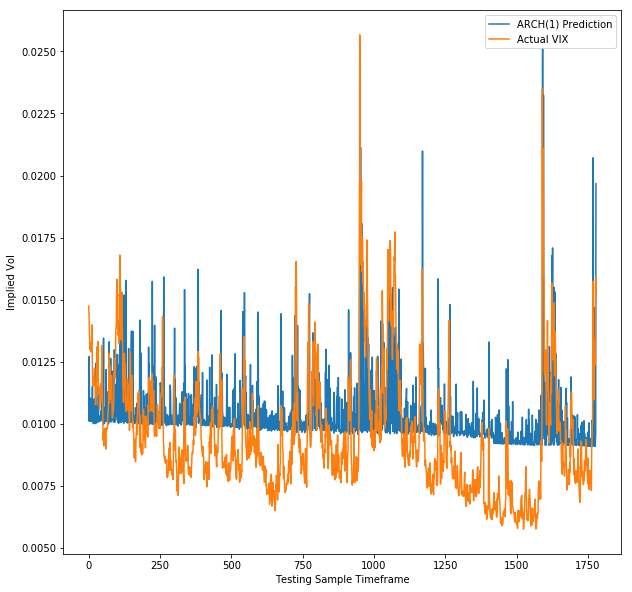

In [274]:
# graph of p = 1
plt.figure(figsize=(10,10))
plt.plot(ARCH_predicted_values_v1)
plt.plot(VIX_actual)
plt.plot()

plt.xticks([250, 500,750, 1000,1250, 1500, 1750], [np.array(testing_dates)[250], np.array(testing_dates)[500],np.array(testing_dates)[750],np.array(testing_dates)[1000],np.array(testing_dates)[1250],np.array(testing_dates)[1500],np.array(testing_dates)[1750] ])
plt.ylabel('Implied Vol')
plt.xlabel('Testing Sample Timeframe')
plt.legend(('ARCH(1) Prediction', 'Actual VIX'))
plt.show()

While this does a reasonable job of forcasting  spikes it doesn't do a great job forcasting the rest of the curve.

# Section 2: GARCH Model

We can follow a similar process as the ARCH(1) model, except the GARCH model has 2 parameters p and q.

Let's try the following combinations of parameters:

    - (1,1)
    - (1,2)
    - (2,1)
    - (2,2)
    - (3,1)
    - (1,3)
    
    
After reading a couple papers on the topic I see that GARCH(1,1) frequently performs the best. We'll see if that's true for this dataset.

In [204]:
%%capture

GARCH_predicted_values_v1 = [] 
GARCH_predicted_values_v2 = []
GARCH_predicted_values_v3 = []
GARCH_predicted_values_v4 = []
GARCH_predicted_values_v5 = []
GARCH_predicted_values_v6 = []

GARCH_model_v1 = arch_model(training_data, mean='Zero', vol='GARCH', p=1, q =1)
GARCH_model_v2 = arch_model(training_data, mean='Zero', vol='GARCH', p=1, q =2)
GARCH_model_v3 = arch_model(training_data, mean='Zero', vol='GARCH', p=2, q =1)
GARCH_model_v4 = arch_model(training_data, mean='Zero', vol='GARCH', p=2, q =2)
GARCH_model_v5 = arch_model(training_data, mean='Zero', vol='GARCH', p=3, q =1)
GARCH_model_v6 = arch_model(training_data, mean='Zero', vol='GARCH', p=1, q =3)

GARCH_model_v1_fit = GARCH_model_v1.fit();
GARCH_model_v2_fit = GARCH_model_v2.fit();
GARCH_model_v3_fit = GARCH_model_v3.fit();
GARCH_model_v4_fit = GARCH_model_v4.fit();
GARCH_model_v5_fit = GARCH_model_v5.fit();
GARCH_model_v6_fit = GARCH_model_v6.fit();

GARCH_predicted_values_v1.append(GARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH_predicted_values_v2.append(GARCH_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH_predicted_values_v3.append(GARCH_model_v3_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH_predicted_values_v4.append(GARCH_model_v4_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH_predicted_values_v5.append(GARCH_model_v5_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH_predicted_values_v6.append(GARCH_model_v6_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

for i in range(1,len(testing_data)):
    comb = np.concatenate((training_data, testing_data[0:i]), axis=0)
    GARCH_model_v1 = arch_model(comb, mean='Zero', vol='GARCH', p=1, q =1)
    GARCH_model_v2 = arch_model(comb, mean='Zero', vol='GARCH', p=1, q =2)
    GARCH_model_v3 = arch_model(comb, mean='Zero', vol='GARCH', p=2, q =1)
    GARCH_model_v4 = arch_model(comb, mean='Zero', vol='GARCH', p=2, q =2)
    GARCH_model_v5 = arch_model(comb, mean='Zero', vol='GARCH', p=3, q =1)
    GARCH_model_v6 = arch_model(comb, mean='Zero', vol='GARCH', p=1, q =3)

    GARCH_model_v1_fit = GARCH_model_v1.fit();
    GARCH_model_v2_fit = GARCH_model_v2.fit();
    GARCH_model_v3_fit = GARCH_model_v3.fit();
    GARCH_model_v4_fit = GARCH_model_v4.fit();
    GARCH_model_v5_fit = GARCH_model_v5.fit();
    GARCH_model_v6_fit = GARCH_model_v6.fit();
    
    GARCH_predicted_values_v1.append(GARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH_predicted_values_v2.append(GARCH_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH_predicted_values_v3.append(GARCH_model_v3_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH_predicted_values_v4.append(GARCH_model_v4_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH_predicted_values_v5.append(GARCH_model_v5_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH_predicted_values_v6.append(GARCH_model_v6_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

In [205]:
GARCH_model_v1_MSE = MSE(np.array(GARCH_predicted_values_v1), VIX_actual, False)
GARCH_model_v1_RMSE = MSE(np.array(GARCH_predicted_values_v1), VIX_actual, True)
GARCH_model_v1_MAE = MAE(np.array(GARCH_predicted_values_v1), VIX_actual)

GARCH_model_v2_MSE = MSE(np.array(GARCH_predicted_values_v2), VIX_actual, False)
GARCH_model_v2_RMSE = MSE(np.array(GARCH_predicted_values_v2), VIX_actual, True)
GARCH_model_v2_MAE = MAE(np.array(GARCH_predicted_values_v2), VIX_actual)

GARCH_model_v3_MSE = MSE(np.array(GARCH_predicted_values_v3), VIX_actual, False)
GARCH_model_v3_RMSE = MSE(np.array(GARCH_predicted_values_v3), VIX_actual, True)
GARCH_model_v3_MAE = MAE(np.array(GARCH_predicted_values_v3), VIX_actual)

GARCH_model_v4_MSE = MSE(np.array(GARCH_predicted_values_v4), VIX_actual, False)
GARCH_model_v4_RMSE = MSE(np.array(GARCH_predicted_values_v4), VIX_actual, True)
GARCH_model_v4_MAE = MAE(np.array(GARCH_predicted_values_v4), VIX_actual)

GARCH_model_v5_MSE = MSE(np.array(GARCH_predicted_values_v5), VIX_actual, False)
GARCH_model_v5_RMSE = MSE(np.array(GARCH_predicted_values_v5), VIX_actual, True)
GARCH_model_v5_MAE = MAE(np.array(GARCH_predicted_values_v5), VIX_actual)

GARCH_model_v6_MSE = MSE(np.array(GARCH_predicted_values_v6), VIX_actual, False)
GARCH_model_v6_RMSE = MSE(np.array(GARCH_predicted_values_v6), VIX_actual, True)
GARCH_model_v6_MAE = MAE(np.array(GARCH_predicted_values_v6), VIX_actual)

##### Now determine which gives a better prediction using MSE, RMSE, and MAE

In [208]:
print('MSE p = 1, q = 1 = ' + str(GARCH_model_v1_MSE))
print('MSE p = 1, q = 2 = ' + str(GARCH_model_v2_MSE))
print('MSE p = 2, q = 1 = ' + str(GARCH_model_v3_MSE))
print('MSE p = 2, q = 2 = ' + str(GARCH_model_v4_MSE))
print('MSE p = 3, q = 1  = ' + str(GARCH_model_v5_MSE))
print('MSE p = 1, q = 3 = ' + str(GARCH_model_v6_MSE))

MSE p = 1, q = 1 = 5.00947300918e-06
MSE p = 1, q = 2 = 4.88547211122e-06
MSE p = 2, q = 1 = 5.1927831565e-06
MSE p = 2, q = 2 = 4.64594756452e-06
MSE p = 3, q = 1  = 5.38233066014e-06
MSE p = 1, q = 3 = 4.33710283111e-06


In [209]:
print('MAE p = 1, q = 1 = ' + str(GARCH_model_v1_MAE))
print('MAE p = 1, q = 2 = ' + str(GARCH_model_v2_MAE))
print('MAE p = 2, q = 1 = ' + str(GARCH_model_v3_MAE))
print('MAE p = 2, q = 2 = ' + str(GARCH_model_v4_MAE))
print('MAE p = 3, q = 1  = ' + str(GARCH_model_v5_MAE))
print('MAE p = 1, q = 3 = ' + str(GARCH_model_v6_MAE))

MAE p = 1, q = 1 = 0.0017367192183
MAE p = 1, q = 2 = 0.0016945403034
MAE p = 2, q = 1 = 0.00175226123732
MAE p = 2, q = 2 = 0.00162471995138
MAE p = 3, q = 1  = 0.00178149367215
MAE p = 1, q = 3 = 0.00155617729931


In [210]:
print('RMSE p = 1, q = 1 = ' + str(GARCH_model_v1_RMSE))
print('RMSE p = 1, q = 2 = ' + str(GARCH_model_v2_RMSE))
print('RMSE p = 2, q = 1 = ' + str(GARCH_model_v3_RMSE))
print('RMSE p = 2, q = 2 = ' + str(GARCH_model_v4_RMSE))
print('RMSE p = 3, q = 1  = ' + str(GARCH_model_v5_RMSE))
print('RMSE p = 1, q = 3 = ' + str(GARCH_model_v6_RMSE))

RMSE p = 1, q = 1 = 0.0022381852044
RMSE p = 1, q = 2 = 0.0022103104106
RMSE p = 2, q = 1 = 0.00227876790317
RMSE p = 2, q = 2 = 0.0021554460245
RMSE p = 3, q = 1  = 0.00231998505602
RMSE p = 1, q = 3 = 0.00208257120673


Interesting, it looks like the GARCH(1,3) model outperforms all of the other GARCH models based on the couple metrics we're using. Let's look at a graph of the GARCH(1,3) against the true values:

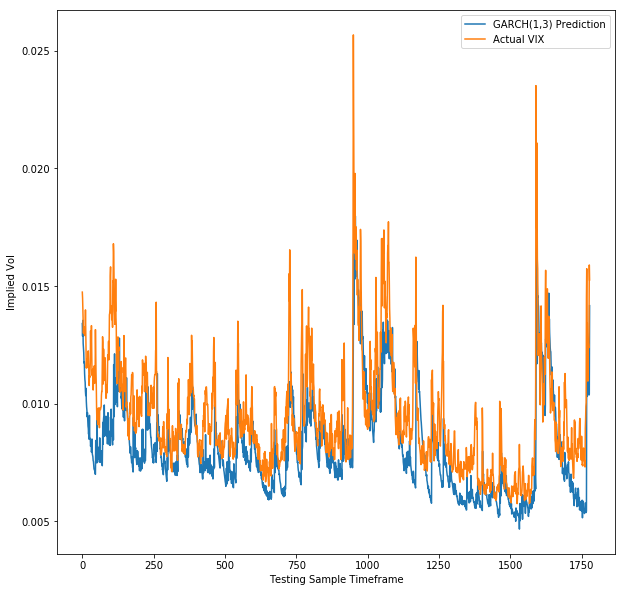

In [211]:
# graph of p = 1, q = 3
plt.figure(figsize=(10,10))
plt.plot(GARCH_predicted_values_v6)
plt.plot(VIX_actual)
plt.plot()

plt.xticks([250, 500,750, 1000,1250, 1500, 1750], [np.array(testing_dates)[250], np.array(testing_dates)[500],np.array(testing_dates)[750],np.array(testing_dates)[1000],np.array(testing_dates)[1250],np.array(testing_dates)[1500],np.array(testing_dates)[1750] ])
plt.ylabel('Implied Vol')
plt.xlabel('Testing Sample Timeframe')
plt.legend(('GARCH(1,3) Prediction', 'Actual VIX'))
plt.show()

Looking at the graph it seems like the GARCH(1,3) does a reasonable job of predicting the VIX. However, it seems to consistently underestimate it. To confirm this suspicion lets graph the error contribution for each day.

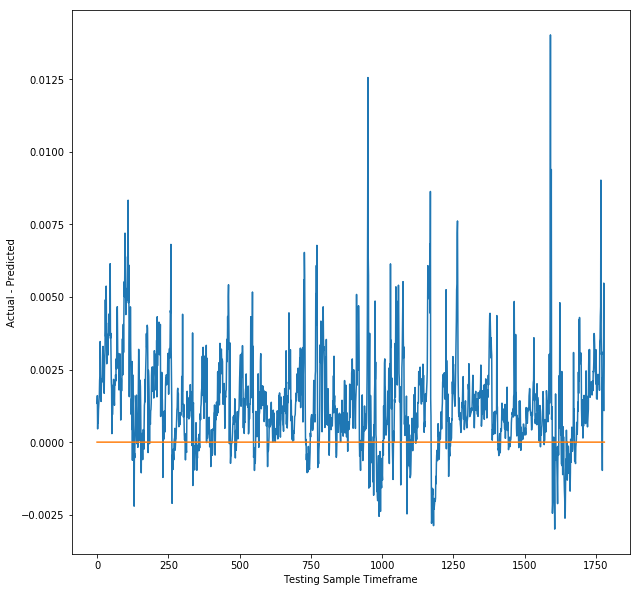

In [236]:
# graph of actual - predicted
plt.figure(figsize=(10,10))
plt.plot(VIX_actual - GARCH_predicted_values_v6)
plt.plot(np.zeros(1780))

plt.plot()
plt.ylabel('Actual - Predicted')
plt.xlabel('Testing Sample Timeframe')
plt.show()

In [227]:
#Let's also get the percent of time that actual > predicted
df = pd.DataFrame(VIX_actual - GARCH_predicted_values_v6)
df.columns = ['a']
positive = df[df.a > 0].count()  
nonPositive = df[df.a <= 0].count()

In [233]:
print('The percent of predictions that are lower than the actual VIX = ' + str(100*round(positive/(positive + nonPositive),2)[0]) + '%')

The percent of predictions that are lower than the actual VIX = 84.0%


This is an extremely high number, and clearly the graph shows this positive bias as well. Although the GARCH(1,3) performed the best out of the GARCH model parameters tested, it definitely could be improved upon further.

# Section 3: HARCH Model

HARCH Models tend to be quite heavy tailed. This may allow for my swings in value and perhaps reduce this underestimating that we saw in the GARCH(1,3) model.

I decided to try a HARCH model with p = 1 and q = 3 to be the same as the chosen best GARCH model

In [251]:
%%capture

HARCH_predicted_values_v1 = [] 

HARCH_model_v1 = arch_model(training_data, mean='Zero', vol='HARCH', p = 1, q = 3)
HARCH_model_v1_fit = HARCH_model_v1.fit();

HARCH_predicted_values_v1.append(HARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

for i in range(1,len(testing_data)):
    comb = np.concatenate((training_data, testing_data[0:i]), axis=0)
    HARCH_model_v1 = arch_model(comb, mean='Zero', vol='HARCH', p = 1, q = 3)
    HARCH_model_v1_fit = HARCH_model_v1.fit(); 
    HARCH_predicted_values_v1.append(HARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    

In [252]:
HARCH_model_v1_MSE = MSE(np.array(HARCH_predicted_values_v1), VIX_actual, False)
HARCH_model_v1_RMSE = MSE(np.array(HARCH_predicted_values_v1), VIX_actual, True)
HARCH_model_v1_MAE = MAE(np.array(HARCH_predicted_values_v1), VIX_actual)

In [253]:
print('MSE HARCH = ' + str(HARCH_model_v1_MSE))

MSE HARCH = 2.23456956928e-05


In [254]:
print('MAE HARCH = ' + str(HARCH_model_v1_MAE))

MAE HARCH = 0.00392905737325


In [255]:
print('RMSE HARCH = ' + str(HARCH_model_v1_RMSE))

RMSE HARCH = 0.00472712340571


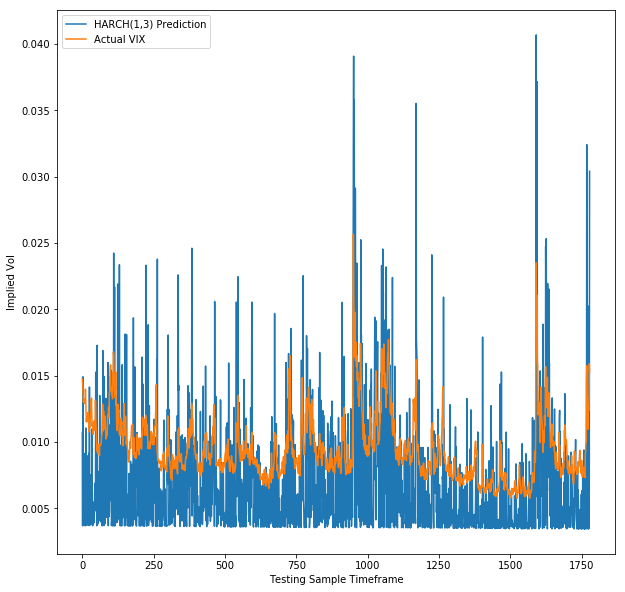

In [256]:
# graph of p = 1, q = 3
plt.figure(figsize=(10,10))
plt.plot(HARCH_predicted_values_v1)
plt.plot(VIX_actual)
plt.plot()

plt.xticks([250, 500,750, 1000,1250, 1500, 1750], [np.array(testing_dates)[250], np.array(testing_dates)[500],np.array(testing_dates)[750],np.array(testing_dates)[1000],np.array(testing_dates)[1250],np.array(testing_dates)[1500],np.array(testing_dates)[1750] ])
plt.ylabel('Implied Vol')
plt.xlabel('Testing Sample Timeframe')
plt.legend(('HARCH(1,3) Prediction', 'Actual VIX'))
plt.show()

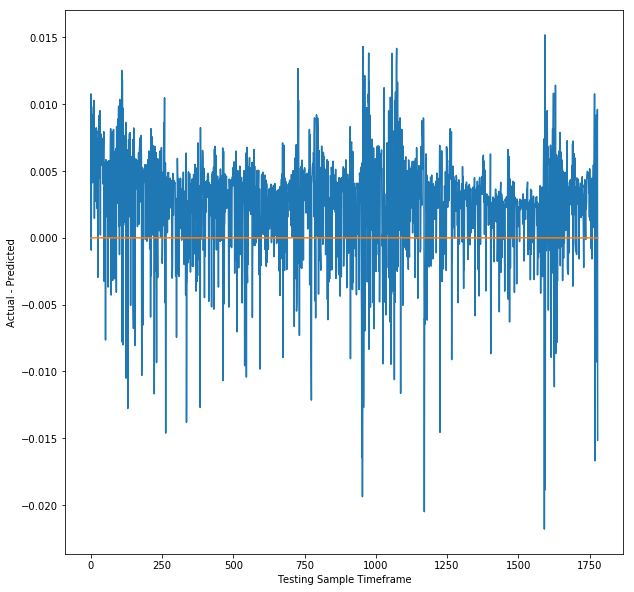

In [258]:
# graph of actual - predicted
plt.figure(figsize=(10,10))
plt.plot(VIX_actual - HARCH_predicted_values_v1)
plt.plot(np.zeros(1780))

plt.plot()
plt.ylabel('Actual - Predicted')
plt.xlabel('Testing Sample Timeframe')
plt.show()

In [259]:
#Let's also get the percent of time that actual > predicted
df = pd.DataFrame(VIX_actual - HARCH_predicted_values_v1)
df.columns = ['a']
positive = df[df.a > 0].count()  
nonPositive = df[df.a <= 0].count()

In [260]:
print('The percent of predictions that are lower than the actual VIX = ' + str(100*round(positive/(positive + nonPositive),2)[0]) + '%')

The percent of predictions that are lower than the actual VIX = 79.0%


It seems like the HARCH Model just made the MSE and MAE values worse. So, I don't think that this model is any better than the Garch(1,3) model. However, it did do what was expected. There are fewer underestimates than GARCH(1,3), and the values seem to be much more extreme than with the GARCH(1,3) model. Again, this is related to those heavy tails.

# Section 4: EGARCH Model

Let's try an EGARCH(1,1) and EGARCH(1,3) model here. The (1,1) model is more of the standard, but we found that the (1,3) GARCH seemed to fit best. So, lets try both

In [261]:
%%capture

EGARCH_predicted_values_v1 = [] 
EGARCH_predicted_values_v2 = [] 

EGARCH_model_v1 = arch_model(training_data, mean='Zero', vol='EGARCH', p = 1, q = 1)
EGARCH_model_v1_fit = EGARCH_model_v1.fit();
EGARCH_predicted_values_v1.append(EGARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

EGARCH_model_v2 = arch_model(training_data, mean='Zero', vol='EGARCH', p = 1, q = 3)
EGARCH_model_v2_fit = EGARCH_model_v2.fit();
EGARCH_predicted_values_v2.append(EGARCH_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)


for i in range(1,len(testing_data)):
    comb = np.concatenate((training_data, testing_data[0:i]), axis=0)
    EGARCH_model_v1 = arch_model(comb, mean='Zero', vol='EGARCH', p = 1, q = 1)
    EGARCH_model_v1_fit = EGARCH_model_v1.fit(); 
    EGARCH_predicted_values_v1.append(EGARCH_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    
    EGARCH_model_v2 = arch_model(comb, mean='Zero', vol='EGARCH', p = 1, q = 3)
    EGARCH_model_v2_fit = EGARCH_model_v2.fit(); 
    EGARCH_predicted_values_v2.append(EGARCH_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

In [262]:
EGARCH_model_v1_MSE = MSE(np.array(EGARCH_predicted_values_v1), VIX_actual, False)
EGARCH_model_v1_RMSE = MSE(np.array(EGARCH_predicted_values_v1), VIX_actual, True)
EGARCH_model_v1_MAE = MAE(np.array(EGARCH_predicted_values_v1), VIX_actual)

EGARCH_model_v2_MSE = MSE(np.array(EGARCH_predicted_values_v2), VIX_actual, False)
EGARCH_model_v2_RMSE = MSE(np.array(EGARCH_predicted_values_v2), VIX_actual, True)
EGARCH_model_v2_MAE = MAE(np.array(EGARCH_predicted_values_v2), VIX_actual)

In [263]:
print('MSE EGARCH(1,1) = ' + str(EGARCH_model_v1_MSE))
print('MSE EGARCH(1,3) = ' + str(EGARCH_model_v2_MSE))

MSE EGARCH(1,1) = 6.43193086629e-06
MSE EGARCH(1,3) = 6.43190733063e-06


In [264]:
print('MAE EGARCH(1,1) = ' + str(EGARCH_model_v1_MAE))
print('MAE EGARCH(1,3) = ' + str(EGARCH_model_v2_MAE))

MAE EGARCH(1,1) = 0.00203102925576
MAE EGARCH(1,3) = 0.00203102263219


In [266]:
print('RMSE EGARCH(1,1) = ' + str(EGARCH_model_v1_RMSE))
print('RMSE EGARCH(1,3) = ' + str(EGARCH_model_v2_RMSE))

RMSE EGARCH(1,1) = 0.00253612516771
RMSE EGARCH(1,3) = 0.00253612052762


These models are almost identical. So, lets just graph the EGARCH(1,3) to remain consistent

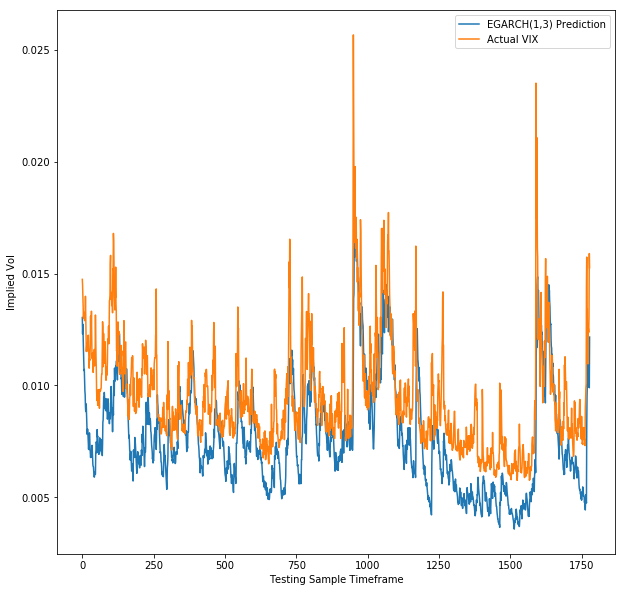

In [268]:
# graph of p = 1, q = 3
plt.figure(figsize=(10,10))
plt.plot(EGARCH_predicted_values_v2)
plt.plot(VIX_actual)
plt.plot()

plt.xticks([250, 500,750, 1000,1250, 1500, 1750], [np.array(testing_dates)[250], np.array(testing_dates)[500],np.array(testing_dates)[750],np.array(testing_dates)[1000],np.array(testing_dates)[1250],np.array(testing_dates)[1500],np.array(testing_dates)[1750] ])
plt.ylabel('Implied Vol')
plt.xlabel('Testing Sample Timeframe')
plt.legend(('EGARCH(1,3) Prediction', 'Actual VIX'))
plt.show()

While the EGARCH model does significantly better than the HARCH Model it still isn't as good of a prediction as the GARCH(1,3) model. So, that one is still the running best model.

# Section 5: Changing the distributions

There are a couple possible underlying distributions that we could change in our model. The default thus far has been to assume a normal distribution, but it could also follow a student t, skewed student t, or other distributions. I used the 4 distributions built into the ARCH class and tested them on the GARCH(1,3) model. The distributions were as follows:

    - Normal (same as before)
    - Student's T
    - Skewed Student's T
    - Generalized Error Model
    
    
Most other papers I read seem to believe that the normal is the best underlying distribution. So, I would expect the other distributions to do worse.

In [280]:
%%capture

GARCH13_predicted_values_v1 = [] 
GARCH13_predicted_values_v2 = []
GARCH13_predicted_values_v3 = []
GARCH13_predicted_values_v4 = []

GARCH13_model_v1 = arch_model(training_data, mean='Zero',dist = 'normal', vol='GARCH', p=1, q =3)
GARCH13_model_v2 = arch_model(training_data, mean='Zero',dist = 't', vol='GARCH', p=1, q =3)
GARCH13_model_v3 = arch_model(training_data, mean='Zero',dist = 'skewstudent', vol='GARCH', p=1, q =3)
GARCH13_model_v4 = arch_model(training_data, mean='Zero',dist = 'ged', vol='GARCH', p=1, q =3)

GARCH13_model_v1_fit = GARCH13_model_v1.fit();
GARCH13_model_v2_fit = GARCH13_model_v2.fit();
GARCH13_model_v3_fit = GARCH13_model_v3.fit();
GARCH13_model_v4_fit = GARCH13_model_v4.fit();

GARCH13_predicted_values_v1.append(GARCH13_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH13_predicted_values_v2.append(GARCH13_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH13_predicted_values_v3.append(GARCH13_model_v3_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH13_predicted_values_v4.append(GARCH13_model_v4_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

for i in range(1,len(testing_data)):
    comb = np.concatenate((training_data, testing_data[0:i]), axis=0)
    GARCH13_model_v1 = arch_model(comb, mean='Zero',dist = 'normal', vol='GARCH', p=1, q =3)
    GARCH13_model_v2 = arch_model(comb, mean='Zero',dist = 't', vol='GARCH', p=1, q =3)
    GARCH13_model_v3 = arch_model(comb, mean='Zero',dist = 'skewstudent', vol='GARCH', p=1, q =3)
    GARCH13_model_v4 = arch_model(comb, mean='Zero',dist = 'ged', vol='GARCH', p=1, q =3)

    GARCH13_model_v1_fit = GARCH13_model_v1.fit();
    GARCH13_model_v2_fit = GARCH13_model_v2.fit();
    GARCH13_model_v3_fit = GARCH13_model_v3.fit();
    GARCH13_model_v4_fit = GARCH13_model_v4.fit();
    
    GARCH13_predicted_values_v1.append(GARCH13_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH13_predicted_values_v2.append(GARCH13_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH13_predicted_values_v3.append(GARCH13_model_v3_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH13_predicted_values_v4.append(GARCH13_model_v4_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

In [281]:
GARCH13_model_v1_MSE = MSE(np.array(GARCH13_predicted_values_v1), VIX_actual, False)
GARCH13_model_v1_RMSE = MSE(np.array(GARCH13_predicted_values_v1), VIX_actual, True)
GARCH13_model_v1_MAE = MAE(np.array(GARCH13_predicted_values_v1), VIX_actual)

GARCH13_model_v2_MSE = MSE(np.array(GARCH13_predicted_values_v2), VIX_actual, False)
GARCH13_model_v2_RMSE = MSE(np.array(GARCH13_predicted_values_v2), VIX_actual, True)
GARCH13_model_v2_MAE = MAE(np.array(GARCH13_predicted_values_v2), VIX_actual)

GARCH13_model_v3_MSE = MSE(np.array(GARCH13_predicted_values_v3), VIX_actual, False)
GARCH13_model_v3_RMSE = MSE(np.array(GARCH13_predicted_values_v3), VIX_actual, True)
GARCH13_model_v3_MAE = MAE(np.array(GARCH13_predicted_values_v3), VIX_actual)

GARCH13_model_v4_MSE = MSE(np.array(GARCH13_predicted_values_v4), VIX_actual, False)
GARCH13_model_v4_RMSE = MSE(np.array(GARCH13_predicted_values_v4), VIX_actual, True)
GARCH13_model_v4_MAE = MAE(np.array(GARCH13_predicted_values_v4), VIX_actual)

In [282]:
print('MSE GARCH(1,3) with Normal = ' + str(GARCH13_model_v1_MSE))
print('MSE GARCH(1,3) with Student T = ' + str(GARCH13_model_v2_MSE))
print('MSE GARCH(1,3) with Skewed Student T = ' + str(GARCH13_model_v3_MSE))
print('MSE GARCH(1,3) with Generalized Error Distribution = ' + str(GARCH13_model_v4_MSE))

MSE GARCH(1,3) with Normal = 4.33710283111e-06
MSE GARCH(1,3) with Student T = 4.5751401665e-06
MSE GARCH(1,3) with Skewed Student T = 4.55985578921e-06
MSE GARCH(1,3) with Generalized Error Distribution = 4.42704971971e-06


In [283]:
print('MAE GARCH(1,3) with Normal = ' + str(GARCH13_model_v1_MAE))
print('MAE GARCH(1,3) with Student T = ' + str(GARCH13_model_v2_MAE))
print('MAE GARCH(1,3) with Skewed Student T = ' + str(GARCH13_model_v3_MAE))
print('MAE GARCH(1,3) with Generalized Error Distribution = ' + str(GARCH13_model_v4_MAE))

MAE GARCH(1,3) with Normal = 0.00155617729931
MAE GARCH(1,3) with Student T = 0.00161223370137
MAE GARCH(1,3) with Skewed Student T = 0.00160885315453
MAE GARCH(1,3) with Generalized Error Distribution = 0.00157488036486


In [284]:
print('RMSE GARCH(1,3) with Normal = ' + str(GARCH13_model_v1_RMSE))
print('RMSE GARCH(1,3) with Student T = ' + str(GARCH13_model_v2_RMSE))
print('RMSE GARCH(1,3) with Skewed Student T = ' + str(GARCH13_model_v3_RMSE))
print('RMSE GARCH(1,3) with Generalized Error Distribution = ' + str(GARCH13_model_v4_RMSE))

RMSE GARCH(1,3) with Normal = 0.00208257120673
RMSE GARCH(1,3) with Student T = 0.00213895772901
RMSE GARCH(1,3) with Skewed Student T = 0.00213538188369
RMSE GARCH(1,3) with Generalized Error Distribution = 0.00210405554102


As expected, the Normal distribution seems to give the smallest error. Let's confirm that all of the models give a similar distribution though when compared to the VIX

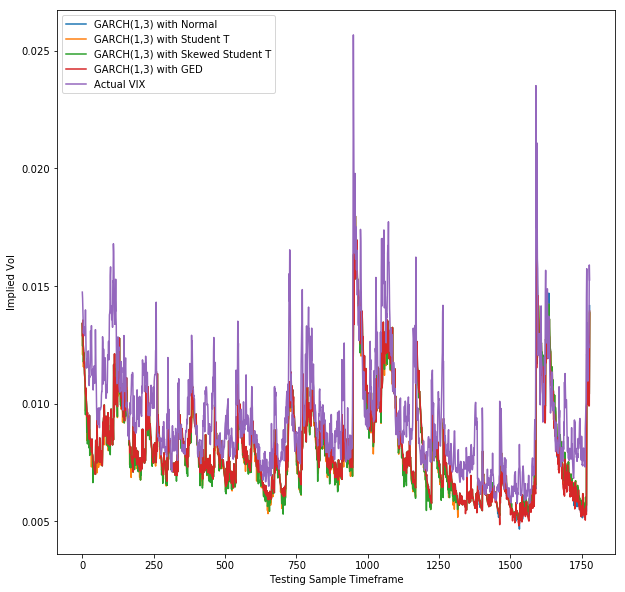

In [285]:
plt.figure(figsize=(10,10))
plt.plot(GARCH13_predicted_values_v1)
plt.plot(GARCH13_predicted_values_v2)
plt.plot(GARCH13_predicted_values_v3)
plt.plot(GARCH13_predicted_values_v4)
plt.plot(VIX_actual)

plt.plot()

plt.xticks([250, 500,750, 1000,1250, 1500, 1750], [np.array(testing_dates)[250], np.array(testing_dates)[500],np.array(testing_dates)[750],np.array(testing_dates)[1000],np.array(testing_dates)[1250],np.array(testing_dates)[1500],np.array(testing_dates)[1750] ])
plt.ylabel('Implied Vol')
plt.xlabel('Testing Sample Timeframe')
plt.legend(('GARCH(1,3) with Normal', 'GARCH(1,3) with Student T','GARCH(1,3) with Skewed Student T','GARCH(1,3) with GED', 'Actual VIX'))
plt.show()

All the predictions show very similar trends. So, I think that the normal distribution is probably best in this case.

# Section 6: Changing the Mean Model of the GARCH(1,3)

Given that we've using the normal distribution, we should also look into what mean model to use. The ARCH class allows for four different means. I tested them all on the GARCH(1,3)
    
    - Zero (default used in previous parts)
    - Constant
    - ARX
    - HARX

In [287]:
%%capture

GARCH13_predicted_values_v1 = [] 
GARCH13_predicted_values_v2 = []
GARCH13_predicted_values_v3 = []
GARCH13_predicted_values_v4 = []

GARCH13_model_v1 = arch_model(training_data, mean='Zero', vol='GARCH', p=1, q =3)
GARCH13_model_v2 = arch_model(training_data, mean='Constant', vol='GARCH', p=1, q =3)
GARCH13_model_v3 = arch_model(training_data, mean='ARX', vol='GARCH', p=1, q =3)
GARCH13_model_v4 = arch_model(training_data, mean='HARX', vol='GARCH', p=1, q =3)

GARCH13_model_v1_fit = GARCH13_model_v1.fit();
GARCH13_model_v2_fit = GARCH13_model_v2.fit();
GARCH13_model_v3_fit = GARCH13_model_v3.fit();
GARCH13_model_v4_fit = GARCH13_model_v4.fit();

GARCH13_predicted_values_v1.append(GARCH13_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH13_predicted_values_v2.append(GARCH13_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH13_predicted_values_v3.append(GARCH13_model_v3_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
GARCH13_predicted_values_v4.append(GARCH13_model_v4_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

for i in range(1,len(testing_data)):
    comb = np.concatenate((training_data, testing_data[0:i]), axis=0)
    GARCH13_model_v1 = arch_model(comb, mean='Zero', vol='GARCH', p=1, q =3)
    GARCH13_model_v2 = arch_model(comb, mean='Constant', vol='GARCH', p=1, q =3)
    GARCH13_model_v3 = arch_model(comb, mean='ARX', vol='GARCH', p=1, q =3)
    GARCH13_model_v4 = arch_model(comb, mean='HARX', vol='GARCH', p=1, q =3)

    GARCH13_model_v1_fit = GARCH13_model_v1.fit();
    GARCH13_model_v2_fit = GARCH13_model_v2.fit();
    GARCH13_model_v3_fit = GARCH13_model_v3.fit();
    GARCH13_model_v4_fit = GARCH13_model_v4.fit();
    
    GARCH13_predicted_values_v1.append(GARCH13_model_v1_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH13_predicted_values_v2.append(GARCH13_model_v2_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH13_predicted_values_v3.append(GARCH13_model_v3_fit.forecast(horizon=1).variance.values[-1][0]**0.5)
    GARCH13_predicted_values_v4.append(GARCH13_model_v4_fit.forecast(horizon=1).variance.values[-1][0]**0.5)

In [288]:
GARCH13_model_v1_MSE = MSE(np.array(GARCH13_predicted_values_v1), VIX_actual, False)
GARCH13_model_v1_RMSE = MSE(np.array(GARCH13_predicted_values_v1), VIX_actual, True)
GARCH13_model_v1_MAE = MAE(np.array(GARCH13_predicted_values_v1), VIX_actual)

GARCH13_model_v2_MSE = MSE(np.array(GARCH13_predicted_values_v2), VIX_actual, False)
GARCH13_model_v2_RMSE = MSE(np.array(GARCH13_predicted_values_v2), VIX_actual, True)
GARCH13_model_v2_MAE = MAE(np.array(GARCH13_predicted_values_v2), VIX_actual)

GARCH13_model_v3_MSE = MSE(np.array(GARCH13_predicted_values_v3), VIX_actual, False)
GARCH13_model_v3_RMSE = MSE(np.array(GARCH13_predicted_values_v3), VIX_actual, True)
GARCH13_model_v3_MAE = MAE(np.array(GARCH13_predicted_values_v3), VIX_actual)

GARCH13_model_v4_MSE = MSE(np.array(GARCH13_predicted_values_v4), VIX_actual, False)
GARCH13_model_v4_RMSE = MSE(np.array(GARCH13_predicted_values_v4), VIX_actual, True)
GARCH13_model_v4_MAE = MAE(np.array(GARCH13_predicted_values_v4), VIX_actual)

In [289]:
print('MSE GARCH(1,3) with Zero = ' + str(GARCH13_model_v1_MSE))
print('MSE GARCH(1,3) with Constant = ' + str(GARCH13_model_v2_MSE))
print('MSE GARCH(1,3) with ARX = ' + str(GARCH13_model_v3_MSE))
print('MSE GARCH(1,3) with HARX = ' + str(GARCH13_model_v4_MSE))

MSE GARCH(1,3) with Zero = 4.33710283111e-06
MSE GARCH(1,3) with Constant = 4.62036673944
MSE GARCH(1,3) with ARX = 4.62036673944
MSE GARCH(1,3) with HARX = 4.62036673944


In [290]:
print('MAE GARCH(1,3) with Zero = ' + str(GARCH13_model_v1_MAE))
print('MAE GARCH(1,3) with Constant = ' + str(GARCH13_model_v2_MAE))
print('MAE GARCH(1,3) with ARX = ' + str(GARCH13_model_v3_MAE))
print('MAE GARCH(1,3) with HARX = ' + str(GARCH13_model_v4_MAE))

MAE GARCH(1,3) with Zero = 0.00155617729931
MAE GARCH(1,3) with Constant = 0.367202085007
MAE GARCH(1,3) with ARX = 0.367202085007
MAE GARCH(1,3) with HARX = 0.367202085007


In [291]:
print('RMSE GARCH(1,3) with Zero = ' + str(GARCH13_model_v1_RMSE))
print('RMSE GARCH(1,3) with Constant = ' + str(GARCH13_model_v2_RMSE))
print('RMSE GARCH(1,3) with ARX = ' + str(GARCH13_model_v3_RMSE))
print('RMSE GARCH(1,3) with HARX = ' + str(GARCH13_model_v4_RMSE))

RMSE GARCH(1,3) with Zero = 0.00208257120673
RMSE GARCH(1,3) with Constant = 2.14950383564
RMSE GARCH(1,3) with ARX = 2.14950383564
RMSE GARCH(1,3) with HARX = 2.14950383564


The clear winner here is Zero (the default)

# Section 7: Conclusion

After compering all of the model we think that a GARCH(1,3) did the best job in predicting the VIX. Therefore, this is the model that we select to do our ultimate VIX prediction on.

In [298]:
final_model_predictions = np.array(GARCH_predicted_values_v6)*((252**0.5)*100)
annualized_VIX_actual = VIX_actual*((252**0.5)*100)

Lets convert these values back to annualized now that we've made a decision on the model

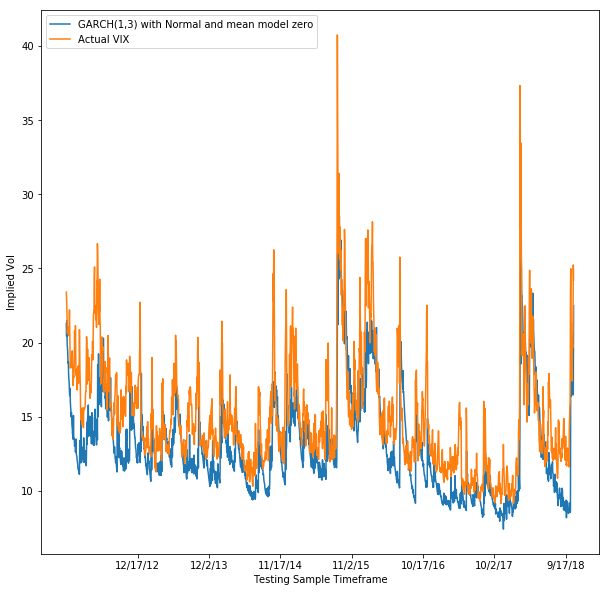

In [316]:
plt.figure(figsize=(10,10))
plt.plot(final_model_predictions)
plt.plot(annualized_VIX_actual)
plt.xticks([250, 500,750, 1000,1250, 1500, 1750], [np.array(testing_dates)[250], np.array(testing_dates)[500],np.array(testing_dates)[750],np.array(testing_dates)[1000],np.array(testing_dates)[1250],np.array(testing_dates)[1500],np.array(testing_dates)[1750] ])

plt.plot()

plt.ylabel('Implied Vol')
plt.xlabel('Testing Sample Timeframe')
plt.legend(('GARCH(1,3) with Normal and mean model zero','Actual VIX'))
plt.show()

In [301]:
#re-copied from above for completeness. Note: the units were not changed to be the same as the annualized graph above
print('MSE p = 1, q = 3 = ' + str(GARCH_model_v6_MSE))
print('MAE p = 1, q = 3 = ' + str(GARCH_model_v6_MAE))
print('RMSE p = 1, q = 3 = ' + str(GARCH_model_v6_RMSE))

MSE p = 1, q = 3 = 4.33710283111e-06
MAE p = 1, q = 3 = 0.00155617729931
RMSE p = 1, q = 3 = 0.00208257120673


# Section 8: Using this model to predict the Largest Spike in the Vix

First we need to find a couple of the largest 1 day (day over day) spikes in volatility. Let's pick the 4 largest spikes and see how well the GARCH(1,3) predicts them.

In [318]:
vix_frame = pd.DataFrame(annualized_VIX_actual)
vix_frame.columns = ['annualized_VIX_actual']

In [321]:
vix_frame.head(2)

,annualized_VIX_actual
0,23.40
1,22.97


In [340]:
vix_frame['Date'] = np.array(testing_dates)
vix_frame['Predicted_Value'] = np.array(final_model_predictions)
vix_frame['daily_change'] = vix_frame.annualized_VIX_actual.diff()
vix_frame['Error'] = vix_frame.annualized_VIX_actual - vix_frame.Predicted_Value

In [341]:
vix_frame.head(2)

,annualized_VIX_actual,daily_change,Date,Predicted_Value,Error
0,23.40,NaN,1/2/12,21.280229,2.119771
1,22.97,-0.43,1/3/12,20.427895,2.542105


In [342]:
vix_frame.sort_values('daily_change').tail(5)

,annualized_VIX_actual,daily_change,Date,Predicted_Value,Error
1169,25.76,8.51,6/24/16,12.060824,13.699176
949,28.03,8.89,8/21/15,15.692942,12.337058
950,40.74,12.71,8/24/15,20.814983,19.925017
1590,37.32,20.01,2/5/18,15.064453,22.255547
0,23.40,NaN,1/2/12,21.280229,2.119771


So, the 4 largest daily increases, their predicted values, and error are from the days above. These errors are so large compared to the errors in the other datapoints because it is quite difficult for a traditional GARCH model to predict massive spikes in volatilty given that its only input is the returns.